# Spiking Metrics

This tutorial demonstrates how to analyze spike train data using `braintools.metric` APIs. We'll cover:

- Raster plot data extraction: `braintools.metric.raster_plot`
- Population firing rates: `braintools.metric.firing_rate`
- Synchrony measures: `braintools.metric.cross_correlation`, `braintools.metric.voltage_fluctuation`
- Functional connectivity: `braintools.metric.functional_connectivity`

All examples use JAX arrays and are compatible with brainunit for dimensional analysis.

In [3]:
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import braintools

# Set random seed for reproducibility
np.random.seed(42)

## Generating Sample Spike Data

Let's create realistic spike data for demonstration.

In [4]:
# Simulation parameters
n_neurons = 50
n_timesteps = 1000
dt = 0.1 * u.ms  # Time step
simulation_time = n_timesteps * dt
times = jnp.arange(n_timesteps) * dt.to_decimal(u.ms)

# Generate spike data with different patterns
# Pattern 1: Random spiking (Poisson-like)
spike_prob = 0.05  # 5% chance of spiking per time step
random_spikes = (np.random.random((n_timesteps, 20)) < spike_prob).astype(float)

# Pattern 2: Synchronous bursts
burst_times = [200, 400, 600, 800]  # Burst at these time indices
sync_spikes = np.zeros((n_timesteps, 15))
for t in burst_times:
    # Add some jitter around burst time
    for i in range(15):
        burst_window = np.arange(max(0, t - 5), min(n_timesteps, t + 5))
        if len(burst_window) > 0:
            spike_time = np.random.choice(burst_window)
            sync_spikes[spike_time, i] = 1.0

# Pattern 3: Oscillatory spiking
freq = 20  # Hz
phase_offset = np.linspace(0, 2 * np.pi, 15)
osc_spikes = np.zeros((n_timesteps, 15))
for i, phase in enumerate(phase_offset):
    oscillation = np.sin(2 * np.pi * freq * times / 1000 + phase)
    # Convert oscillation to spikes (threshold crossing)
    spike_times = np.where((oscillation[:-1] < 0.5) & (oscillation[1:] >= 0.5))[0]
    osc_spikes[spike_times, i] = 1.0

# Combine all patterns
spike_matrix = np.concatenate([random_spikes, sync_spikes, osc_spikes], axis=1)
spike_matrix = jnp.array(spike_matrix)

print(f"Spike matrix shape: {spike_matrix.shape}")
print(f"Total spikes: {jnp.sum(spike_matrix)}")
print(f"Average firing rate: {jnp.mean(spike_matrix) / (dt.to_decimal(u.second)):.2f} Hz")

Spike matrix shape: (1000, 50)
Total spikes: 1079.0
Average firing rate: 215.80 Hz


## 1. Raster Plot Data Extraction

Extract spike times and neuron indices for visualization.

Number of spikes extracted: 1079
Neuron indices range: 0 to 49
Time range: 0.0 to 99.9 ms


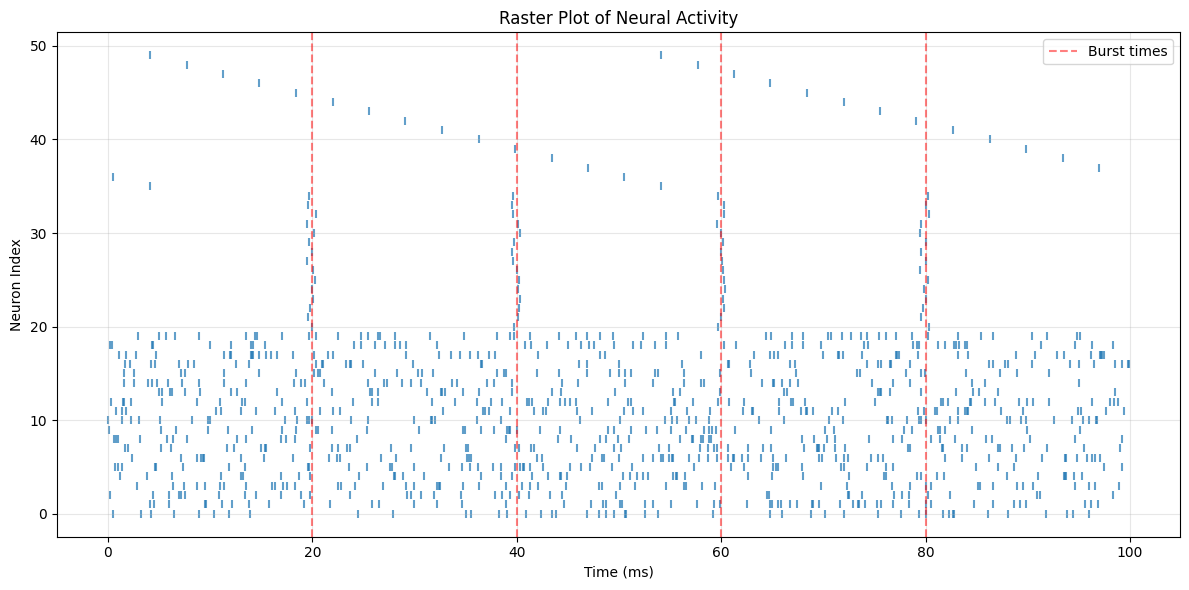

In [5]:
# Extract raster plot data
neuron_indices, spike_times = braintools.metric.raster_plot(spike_matrix, times)

print(f"Number of spikes extracted: {len(spike_times)}")
print(f"Neuron indices range: {neuron_indices.min()} to {neuron_indices.max()}")
print(f"Time range: {spike_times.min():.1f} to {spike_times.max():.1f} ms")

# Create raster plot
plt.figure(figsize=(12, 6))
plt.scatter(spike_times, neuron_indices, marker='|', s=30, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Raster Plot of Neural Activity')
plt.grid(True, alpha=0.3)

# Add vertical lines to highlight burst times
for t in [t * dt.to_decimal(u.ms) for t in burst_times]:
    plt.axvline(t, color='red', linestyle='--', alpha=0.5,
                label='Burst times' if t == burst_times[0] * dt.to_decimal(u.ms) else '')

plt.legend()
plt.tight_layout()
plt.show()

## 2. Population Firing Rate

Calculate smoothed population firing rates to understand overall network activity.

Rate shapes: (1000,)
Mean rates: 225.6, 217.5, 212.9 Hz


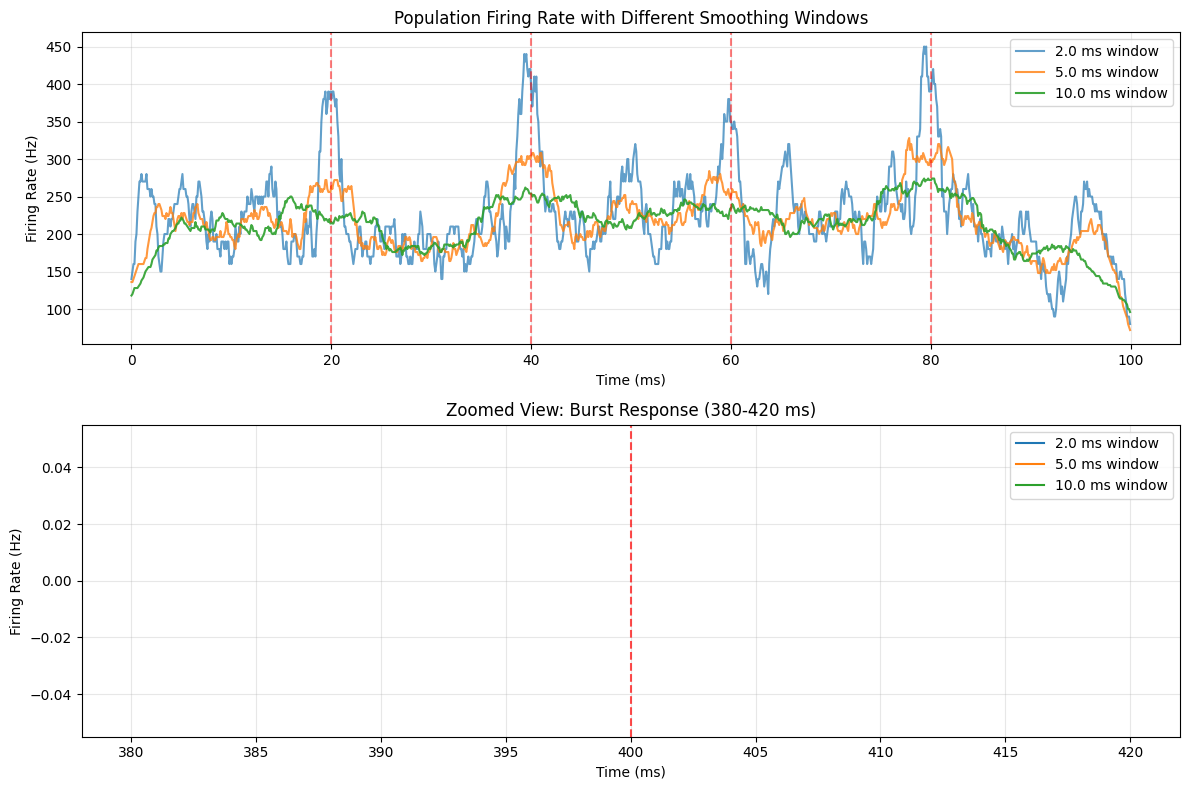

In [6]:
# Calculate firing rates with different smoothing windows
narrow_window = 2 * u.ms
medium_window = 5 * u.ms
wide_window = 10 * u.ms

rate_narrow = braintools.metric.firing_rate(spike_matrix, narrow_window, dt)
rate_medium = braintools.metric.firing_rate(spike_matrix, medium_window, dt)
rate_wide = braintools.metric.firing_rate(spike_matrix, wide_window, dt)

print(f"Rate shapes: {rate_narrow.shape}")
print(f"Mean rates: {jnp.mean(rate_narrow):.1f}, {jnp.mean(rate_medium):.1f}, {jnp.mean(rate_wide):.1f} Hz")

# Plot firing rates
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(times, rate_narrow, label=f'{float(narrow_window.to_decimal(u.ms))} ms window', alpha=0.7)
plt.plot(times, rate_medium, label=f'{float(medium_window.to_decimal(u.ms))} ms window', alpha=0.8)
plt.plot(times, rate_wide, label=f'{float(wide_window.to_decimal(u.ms))} ms window', alpha=0.9)
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Population Firing Rate with Different Smoothing Windows')
plt.legend()
plt.grid(True, alpha=0.3)

# Add burst time markers
for t in [t * dt.to_decimal(u.ms) for t in burst_times]:
    plt.axvline(t, color='red', linestyle='--', alpha=0.5)

# Zoom in on a burst period
plt.subplot(2, 1, 2)
zoom_start, zoom_end = 380, 420
zoom_mask = (times >= zoom_start) & (times <= zoom_end)
plt.plot(times[zoom_mask], rate_narrow[zoom_mask], label=f'{float(narrow_window.to_decimal(u.ms))} ms window')
plt.plot(times[zoom_mask], rate_medium[zoom_mask], label=f'{float(medium_window.to_decimal(u.ms))} ms window')
plt.plot(times[zoom_mask], rate_wide[zoom_mask], label=f'{float(wide_window.to_decimal(u.ms))} ms window')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title(f'Zoomed View: Burst Response ({zoom_start}-{zoom_end} ms)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(400, color='red', linestyle='--', alpha=0.7, label='Burst time')

plt.tight_layout()
plt.show()

## 3. Synchrony Measures

Quantify neural synchronization using cross-correlation and voltage fluctuation methods.

D:\codes\projects\braintools\braintools\metric\_correlation.py:119: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  states = jnp.asarray(jnp.sum(states, axis=2) > 0., dtype=jnp.float_)


Population synchronization index: 0.3954
Random group synchrony: 0.9108
Burst group synchrony: 0.5143
Oscillatory group synchrony: 0.0571


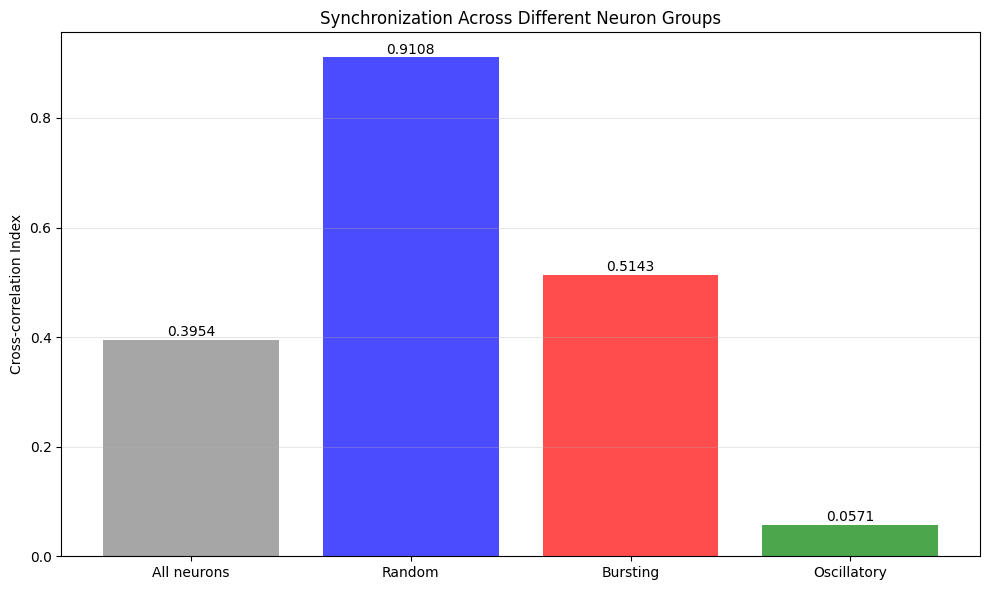

In [7]:
# 3.1 Cross-correlation based synchrony
sync_index = braintools.metric.cross_correlation(spike_matrix, bin=5.0, dt=dt.to_decimal(u.ms))
print(f"Population synchronization index: {sync_index:.4f}")

# Compare synchrony for different neuron groups
random_neurons = spike_matrix[:, :20]  # Random spiking neurons
sync_neurons = spike_matrix[:, 20:35]  # Synchronous bursting neurons
osc_neurons = spike_matrix[:, 35:]  # Oscillatory neurons

sync_random = braintools.metric.cross_correlation(random_neurons, bin=5.0, dt=dt.to_decimal(u.ms))
sync_burst = braintools.metric.cross_correlation(sync_neurons, bin=5.0, dt=dt.to_decimal(u.ms))
sync_osc = braintools.metric.cross_correlation(osc_neurons, bin=5.0, dt=dt.to_decimal(u.ms))

print(f"Random group synchrony: {sync_random:.4f}")
print(f"Burst group synchrony: {sync_burst:.4f}")
print(f"Oscillatory group synchrony: {sync_osc:.4f}")

# Visualize synchrony comparison
plt.figure(figsize=(10, 6))
groups = ['All neurons', 'Random', 'Bursting', 'Oscillatory']
sync_values = [sync_index, sync_random, sync_burst, sync_osc]
colors = ['gray', 'blue', 'red', 'green']

bars = plt.bar(groups, sync_values, color=colors, alpha=0.7)
plt.ylabel('Cross-correlation Index')
plt.title('Synchronization Across Different Neuron Groups')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, sync_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 4. Voltage Fluctuation Synchrony

Generate synthetic membrane potential data and analyze synchrony.

Voltage synchrony (synchronized): 0.9863
Voltage synchrony (asynchronous): 0.0758


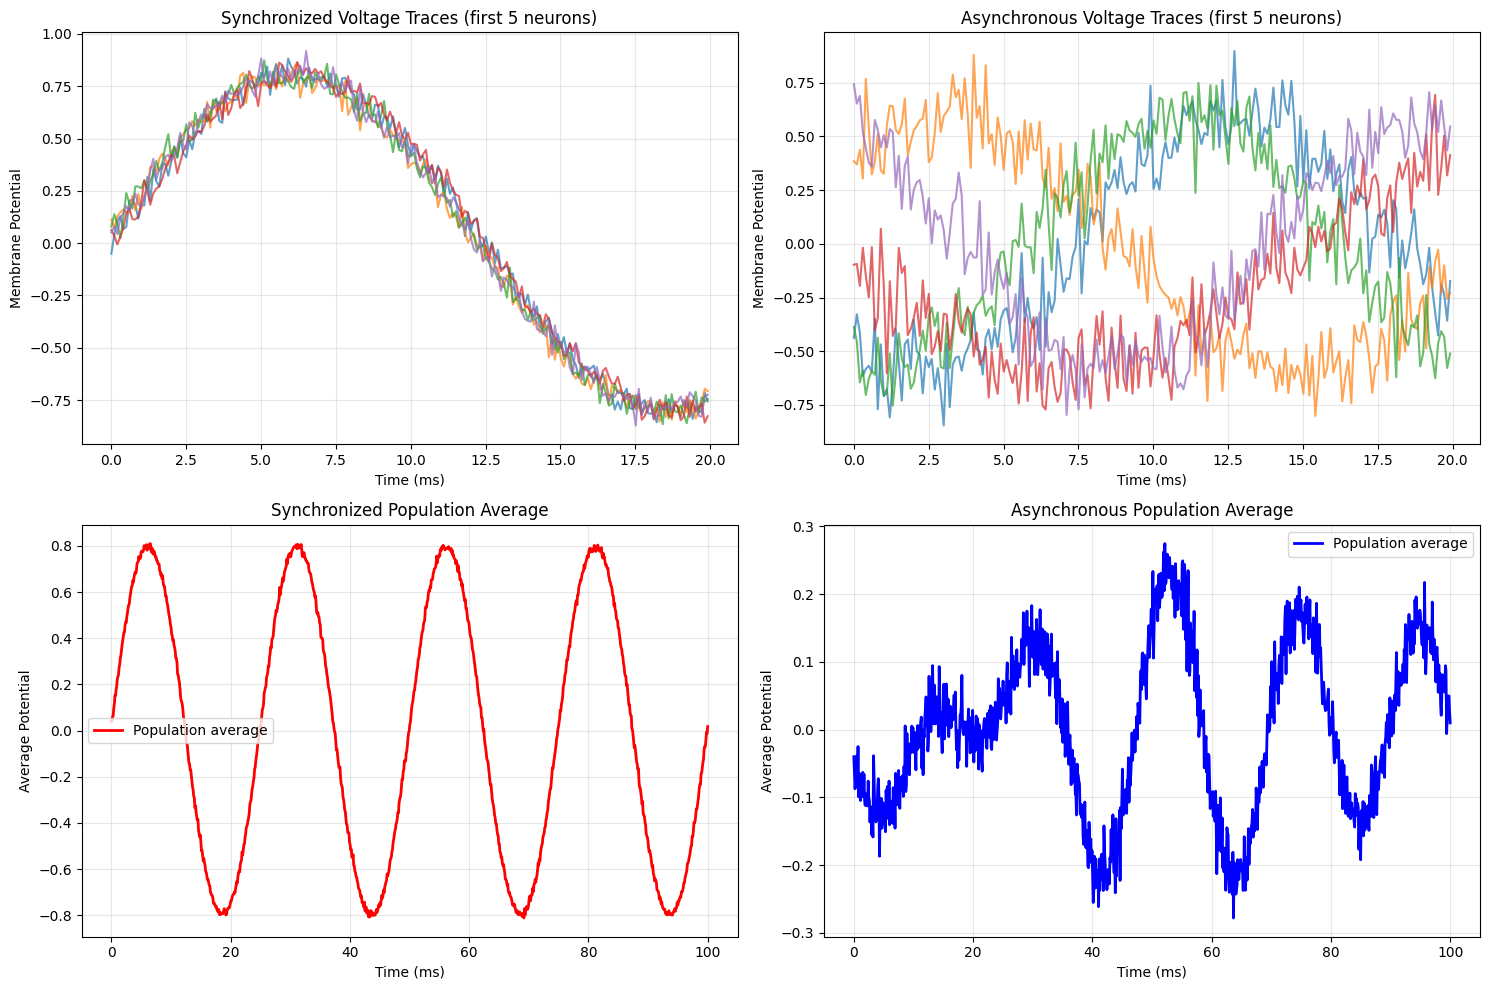

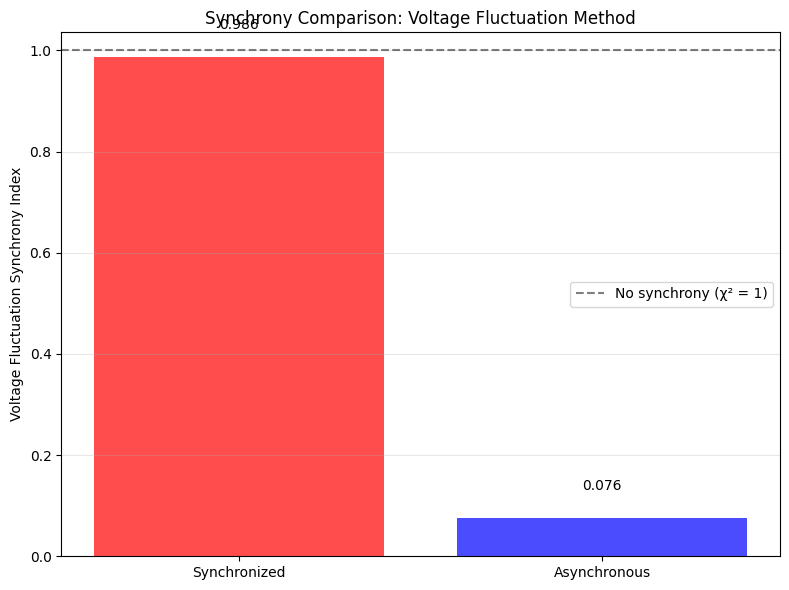

In [8]:
# Generate synthetic membrane potential data
# Scenario 1: Synchronized oscillations + noise
t_volt = jnp.linspace(0, 100, 1000)  # 100 ms, 1000 time points
base_freq = 40  # Hz
common_signal = jnp.sin(2 * jnp.pi * base_freq * t_volt / 1000)

# Add individual noise and phase differences
n_cells = 20
sync_voltages = []
async_voltages = []

for i in range(n_cells):
    # Synchronized case: common signal + small individual noise
    phase_shift = np.random.normal(0, 0.1)  # Small phase jitter
    sync_signal = jnp.sin(2 * jnp.pi * base_freq * t_volt / 1000 + phase_shift)
    noise = np.random.normal(0, 0.2, len(t_volt))
    sync_voltages.append(0.8 * sync_signal + 0.2 * noise)

    # Asynchronous case: independent oscillations + noise
    individual_freq = base_freq + np.random.normal(0, 10)  # Frequency variation
    individual_phase = np.random.uniform(0, 2 * np.pi)
    async_signal = jnp.sin(2 * jnp.pi * individual_freq * t_volt / 1000 + individual_phase)
    noise = np.random.normal(0, 0.3, len(t_volt))
    async_voltages.append(0.6 * async_signal + 0.4 * noise)

sync_voltage_matrix = jnp.array(sync_voltages).T
async_voltage_matrix = jnp.array(async_voltages).T

# Calculate voltage fluctuation synchrony
sync_index_volt_sync = braintools.metric.voltage_fluctuation(sync_voltage_matrix)
sync_index_volt_async = braintools.metric.voltage_fluctuation(async_voltage_matrix)

print(f"Voltage synchrony (synchronized): {sync_index_volt_sync:.4f}")
print(f"Voltage synchrony (asynchronous): {sync_index_volt_async:.4f}")

# Visualize voltage traces and synchrony
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot sample voltage traces
axes[0, 0].plot(t_volt[:200], sync_voltage_matrix[:200, :5], alpha=0.7)
axes[0, 0].set_title('Synchronized Voltage Traces (first 5 neurons)')
axes[0, 0].set_xlabel('Time (ms)')
axes[0, 0].set_ylabel('Membrane Potential')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(t_volt[:200], async_voltage_matrix[:200, :5], alpha=0.7)
axes[0, 1].set_title('Asynchronous Voltage Traces (first 5 neurons)')
axes[0, 1].set_xlabel('Time (ms)')
axes[0, 1].set_ylabel('Membrane Potential')
axes[0, 1].grid(True, alpha=0.3)

# Plot population averages
axes[1, 0].plot(t_volt, jnp.mean(sync_voltage_matrix, axis=1), 'r-', linewidth=2, label='Population average')
axes[1, 0].set_title('Synchronized Population Average')
axes[1, 0].set_xlabel('Time (ms)')
axes[1, 0].set_ylabel('Average Potential')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].plot(t_volt, jnp.mean(async_voltage_matrix, axis=1), 'b-', linewidth=2, label='Population average')
axes[1, 1].set_title('Asynchronous Population Average')
axes[1, 1].set_xlabel('Time (ms)')
axes[1, 1].set_ylabel('Average Potential')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Compare synchrony indices
plt.figure(figsize=(8, 6))
conditions = ['Synchronized', 'Asynchronous']
sync_indices = [sync_index_volt_sync, sync_index_volt_async]
colors = ['red', 'blue']

bars = plt.bar(conditions, sync_indices, color=colors, alpha=0.7)
plt.ylabel('Voltage Fluctuation Synchrony Index')
plt.title('Synchrony Comparison: Voltage Fluctuation Method')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, sync_indices):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom')

plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='No synchrony (χ² = 1)')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Functional Connectivity

Analyze statistical dependencies between neurons using correlation-based connectivity.

Functional connectivity matrix shape: (50, 50)
Connectivity range: -0.306 to 1.000


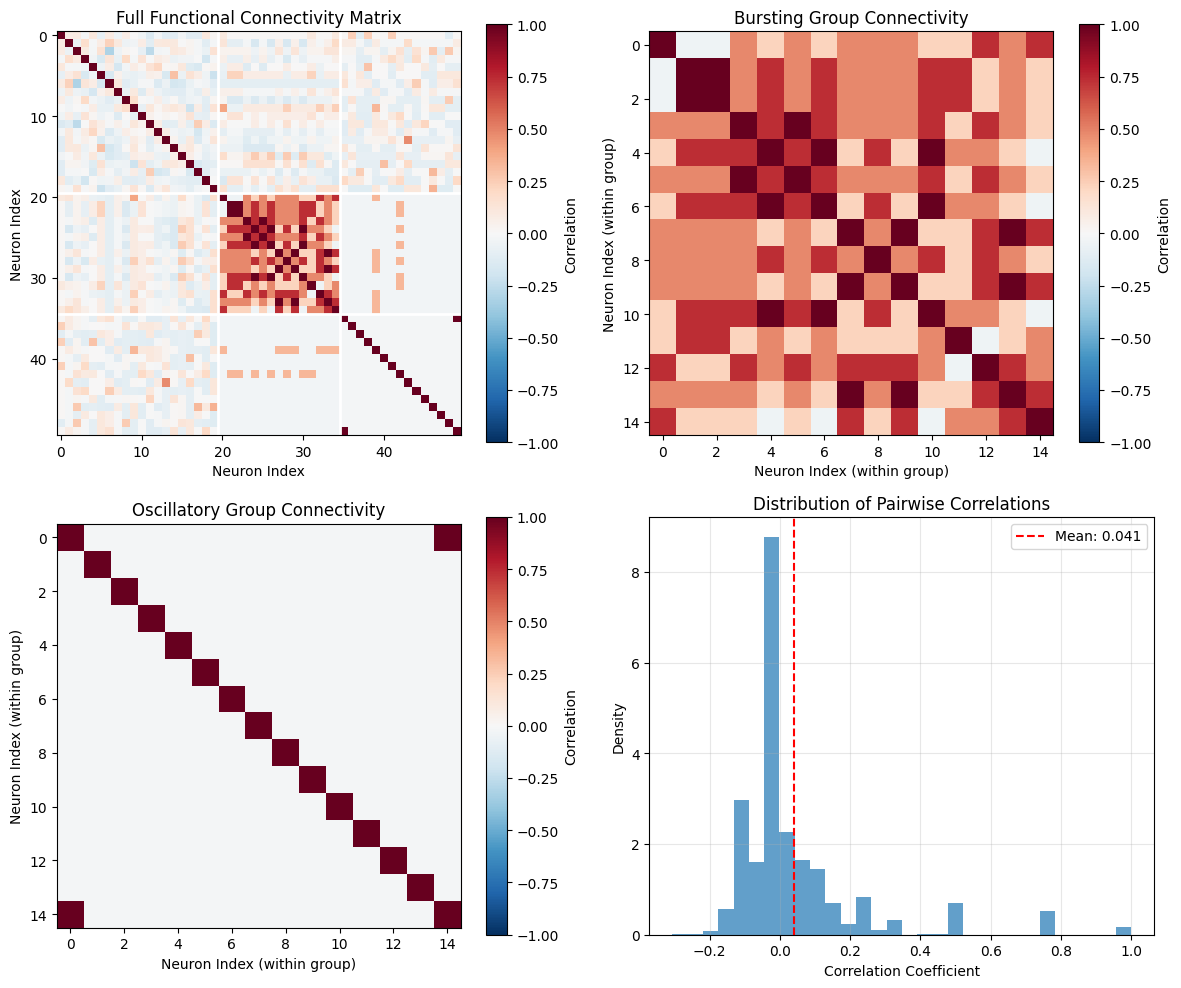


Connectivity Summary:
Mean correlation: 0.0413
Std correlation: 0.1846
Max correlation: 1.0000
Min correlation: -0.3061

Group-wise connectivity:
Random group mean: -0.0102
Burst group mean: 0.4940
Oscillatory group mean: -0.0107


In [9]:
# Calculate functional connectivity from spike data
# Convert spikes to firing rates for connectivity analysis
window_size = 10  # Bin size for rate calculation
n_bins = n_timesteps // window_size
binned_rates = spike_matrix[:n_bins * window_size].reshape(n_bins, window_size, n_neurons).sum(axis=1)

# Compute functional connectivity matrix
fc_matrix = braintools.metric.functional_connectivity(binned_rates)

print(f"Functional connectivity matrix shape: {fc_matrix.shape}")
print(f"Connectivity range: {jnp.min(fc_matrix):.3f} to {jnp.max(fc_matrix):.3f}")

# Visualize connectivity matrix
plt.figure(figsize=(12, 10))

# Full connectivity matrix
plt.subplot(2, 2, 1)
im1 = plt.imshow(fc_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Full Functional Connectivity Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.colorbar(im1, label='Correlation')

# Add group boundaries
for boundary in [20, 35]:
    plt.axhline(boundary - 0.5, color='white', linewidth=2)
    plt.axvline(boundary - 0.5, color='white', linewidth=2)

# Within-group connectivity (bursting neurons)
plt.subplot(2, 2, 2)
burst_fc = fc_matrix[20:35, 20:35]
im2 = plt.imshow(burst_fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Bursting Group Connectivity')
plt.xlabel('Neuron Index (within group)')
plt.ylabel('Neuron Index (within group)')
plt.colorbar(im2, label='Correlation')

# Within-group connectivity (oscillatory neurons)
plt.subplot(2, 2, 3)
osc_fc = fc_matrix[35:, 35:]
im3 = plt.imshow(osc_fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Oscillatory Group Connectivity')
plt.xlabel('Neuron Index (within group)')
plt.ylabel('Neuron Index (within group)')
plt.colorbar(im3, label='Correlation')

# Connectivity strength distribution
plt.subplot(2, 2, 4)
# Extract upper triangular part (exclude diagonal)
upper_tri_indices = jnp.triu_indices_from(fc_matrix, k=1)
connectivity_values = fc_matrix[upper_tri_indices]

plt.hist(connectivity_values, bins=30, alpha=0.7, density=True)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Distribution of Pairwise Correlations')
plt.axvline(jnp.mean(connectivity_values), color='red', linestyle='--',
            label=f'Mean: {jnp.mean(connectivity_values):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate summary statistics
print(f"\nConnectivity Summary:")
print(f"Mean correlation: {jnp.mean(connectivity_values):.4f}")
print(f"Std correlation: {jnp.std(connectivity_values):.4f}")
print(f"Max correlation: {jnp.max(connectivity_values):.4f}")
print(f"Min correlation: {jnp.min(connectivity_values):.4f}")

# Group-specific connectivity
random_indices = jnp.triu_indices_from(fc_matrix[:20, :20], k=1)
burst_indices = jnp.triu_indices_from(burst_fc, k=1)
osc_indices = jnp.triu_indices_from(osc_fc, k=1)

print(f"\nGroup-wise connectivity:")
print(f"Random group mean: {jnp.mean(fc_matrix[:20, :20][random_indices]):.4f}")
print(f"Burst group mean: {jnp.mean(burst_fc[burst_indices]):.4f}")
print(f"Oscillatory group mean: {jnp.mean(osc_fc[osc_indices]):.4f}")

## 6. Comparing Synchrony Measures

Compare different synchrony measures on the same data.

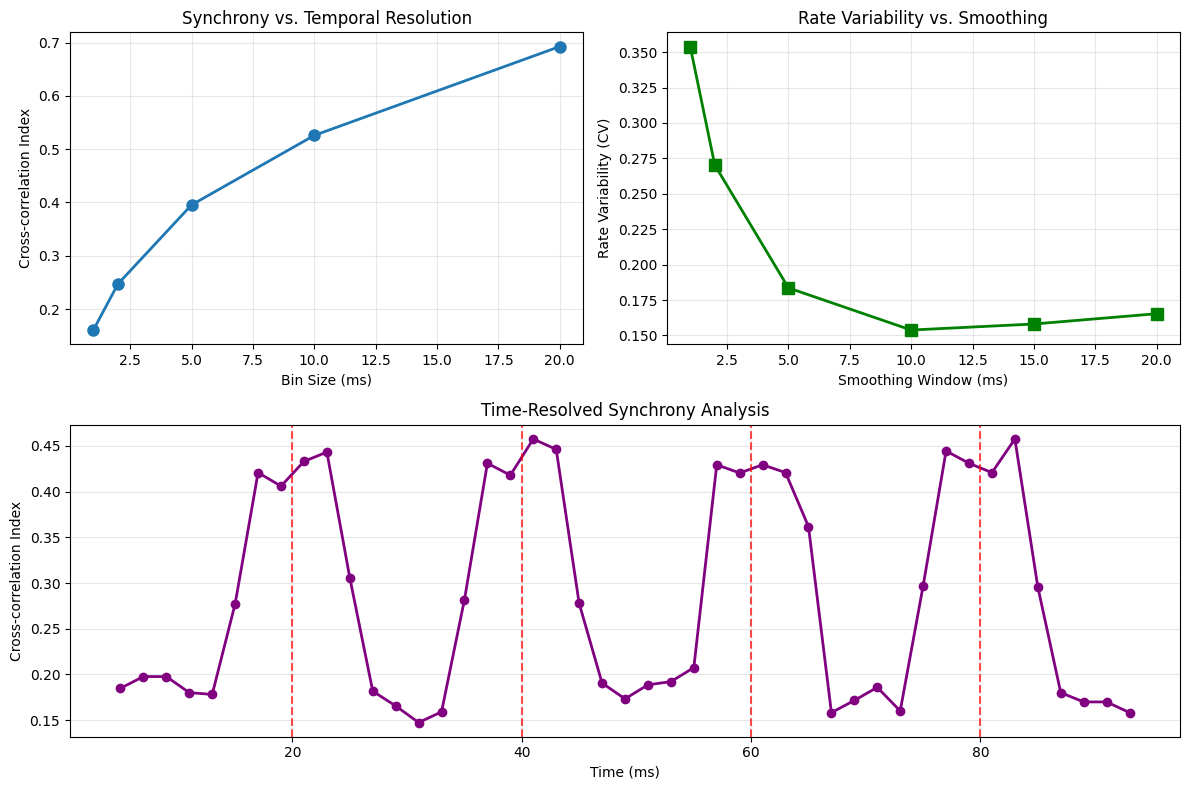

Synchrony varies with bin size from 0.1607 to 0.6927
Rate variability decreases with smoothing from 0.354 to 0.154


In [10]:
# Compare synchrony measures across different bin sizes
bin_sizes = [1.0, 2.0, 5.0, 10.0, 20.0]  # ms
cross_corr_values = []

for bin_size in bin_sizes:
    sync_val = braintools.metric.cross_correlation(spike_matrix, bin=bin_size, dt=dt.to_decimal(u.ms))
    cross_corr_values.append(sync_val)

plt.figure(figsize=(12, 8))

# Plot synchrony vs bin size
plt.subplot(2, 2, 1)
plt.plot(bin_sizes, cross_corr_values, 'o-', linewidth=2, markersize=8)
plt.xlabel('Bin Size (ms)')
plt.ylabel('Cross-correlation Index')
plt.title('Synchrony vs. Temporal Resolution')
plt.grid(True, alpha=0.3)

# Compare firing rate smoothing windows
smoothing_windows = [1, 2, 5, 10, 15, 20] * u.ms
rate_variability = []

for window in smoothing_windows:
    rate = braintools.metric.firing_rate(spike_matrix, window, dt)
    # Calculate coefficient of variation
    cv = jnp.std(rate) / jnp.mean(rate)
    rate_variability.append(cv)

plt.subplot(2, 2, 2)
window_values = [float(w.to_decimal(u.ms)) for w in smoothing_windows]
plt.plot(window_values, rate_variability, 's-', linewidth=2, markersize=8, color='green')
plt.xlabel('Smoothing Window (ms)')
plt.ylabel('Rate Variability (CV)')
plt.title('Rate Variability vs. Smoothing')
plt.grid(True, alpha=0.3)

# Time-resolved synchrony analysis
plt.subplot(2, 1, 2)
window_duration = 100  # Time steps
step_size = 20
time_resolved_sync = []
time_centers = []

for start_idx in range(0, n_timesteps - window_duration, step_size):
    end_idx = start_idx + window_duration
    window_spikes = spike_matrix[start_idx:end_idx, :]

    if jnp.sum(window_spikes) > 0:  # Only analyze if there are spikes
        sync_val = braintools.metric.cross_correlation(window_spikes, bin=5.0, dt=dt.to_decimal(u.ms))
        time_resolved_sync.append(sync_val)
        time_centers.append((start_idx + end_idx) / 2 * dt.to_decimal(u.ms))

plt.plot(time_centers, time_resolved_sync, 'o-', linewidth=2, markersize=6, color='purple')
plt.xlabel('Time (ms)')
plt.ylabel('Cross-correlation Index')
plt.title('Time-Resolved Synchrony Analysis')
plt.grid(True, alpha=0.3)

# Mark burst times
for t in [t * dt.to_decimal(u.ms) for t in burst_times]:
    plt.axvline(t, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Synchrony varies with bin size from {min(cross_corr_values):.4f} to {max(cross_corr_values):.4f}")
print(f"Rate variability decreases with smoothing from {max(rate_variability):.3f} to {min(rate_variability):.3f}")

## Summary and Best Practices

Key Functions:

1. **`bt.metric.raster_plot(spike_matrix, times)`**: Extract spike times and neuron indices for visualization
2. **`bt.metric.firing_rate(spikes, window, dt)`**: Calculate smoothed population firing rates
3. **`bt.metric.cross_correlation(spikes, bin, dt)`**: Measure pairwise spike train synchrony
4. **`bt.metric.voltage_fluctuation(potentials)`**: Quantify voltage-based synchrony
5. **`bt.metric.functional_connectivity(activities)`**: Compute correlation-based connectivity matrices

est Practices:

- **Raster plots**: Use for visualizing spike timing patterns and identifying synchronous events
- **Firing rates**: Choose smoothing windows based on timescales of interest (1-10 ms for fast dynamics)
- **Cross-correlation**: Adjust bin size to match relevant temporal precision (1-20 ms typical)
- **Voltage synchrony**: Best for continuous membrane potential data
- **Functional connectivity**: Use sufficient data length for stable correlation estimates

Parameter Selection:

- **Temporal resolution**: Match analysis timescales to biological processes
- **Bin sizes**: Smaller bins → higher temporal resolution but more noise
- **Smoothing windows**: Wider windows → more stable estimates but lower temporal resolution
- **Data length**: Longer recordings → more reliable statistics

Common Interpretations:

- **Cross-correlation index ≈ 0**: Asynchronous firing
- **Cross-correlation index > 0.5**: Moderate synchrony
- **Cross-correlation index > 0.8**: High synchrony
- **Voltage fluctuation χ² ≈ 1**: No synchronization
- **Voltage fluctuation χ² >> 1**: Strong synchronization